In [1]:
import os
import gc
import sys
import joblib
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from datetime import datetime
from argparse import Namespace
from collections import defaultdict
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, GroupKFold, train_test_split, KFold

import lightgbm as lgb
from lightgbm import LGBMRegressor

import matplotlib.style as style
style.use('fivethirtyeight') 

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
args = Namespace(
    train=True,
    optimize=False,
    train_l2=False,
    inference=False,
    seed=21,
    folds=5,
    workers=4,
    min_time_id=None, 
    holdout=False,
    cv_method="single",
    num_bins=16,
    holdout_size=100,
    outlier_threshold=0.005,
    trading_days_per_year=250,   # chinese stock market trading days per year (roughly)
    add_investment_id_model=False,
#     data_path=Path("../input/ubiquant-parquet"),
    data_path=Path(""),
    just_eda=True,
)
seed_everything(args.seed)

assert args.cv_method in {"single", "kfold", "group", "stratified", "time", "group_time", "time_range"}, "unknown cv method"
assert args.data_path.exists(), "data_path not exists"

In [3]:
%%time
train = pd.read_parquet(args.data_path.joinpath("train_low_mem.parquet"))
# assert train.isnull().any().sum() == 0, "null exists."
# assert train.row_id.str.extract(r"(?P<time_id>\d+)_(?P<investment_id>\d+)").astype(train.time_id.dtype).equals(train[["time_id", "investment_id"]]), "row_id!=time_id_investment_id"
# assert train.time_id.is_monotonic_increasing, "time_id not monotonic increasing"

CPU times: user 2.33 s, sys: 746 ms, total: 3.07 s
Wall time: 3.07 s


# Features EDA + processing

### Possible outliers

0.10802400507032894

-0.22408594757318495

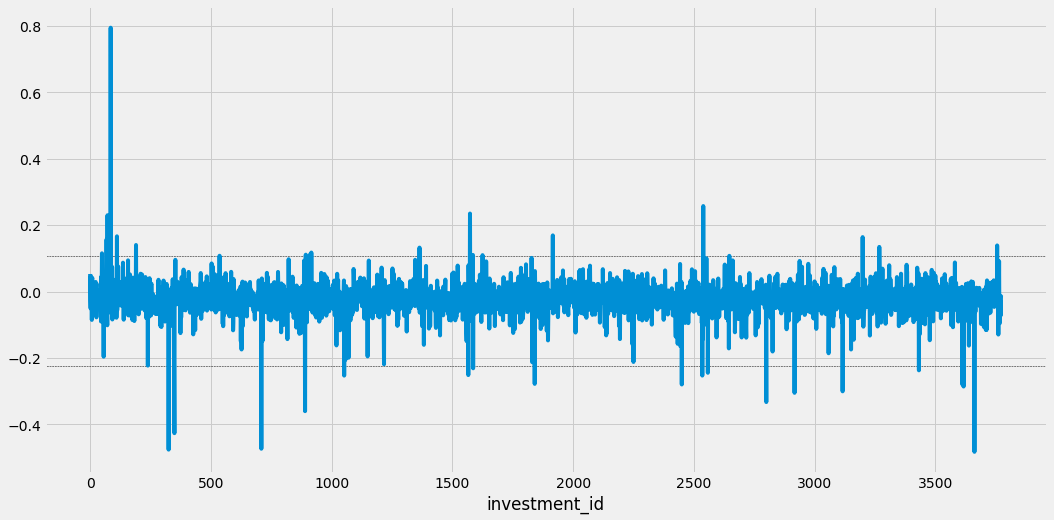

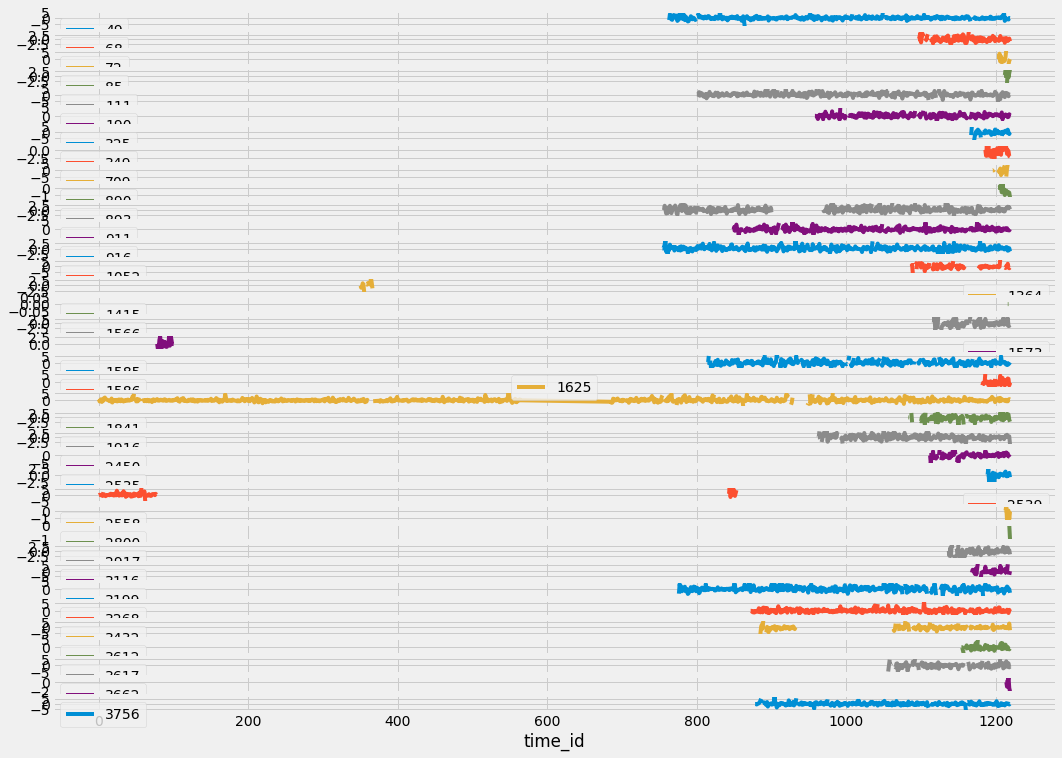

In [4]:
df = train[["investment_id", "target"]].groupby("investment_id").target.mean()
upper_bound, lower_bound = df.quantile([1-args.outlier_threshold, args.outlier_threshold])
display(upper_bound, lower_bound)
ax = df.plot(figsize=(16, 8))
ax.axhspan(lower_bound, upper_bound, fill=False, linestyle="--", color="k")
plt.show()

outlier_investments = df.loc[(df>upper_bound)|(df<lower_bound)|(df==0)].index
_=pd.pivot(
    train.loc[train.investment_id.isin(outlier_investments), ["investment_id", "time_id", "target"]],
    index='time_id', columns='investment_id', values='target'
).plot(figsize=(16,12), subplots=True, sharex=True)

# Drop indexes with feature outliers: [notebook](https://www.kaggle.com/junjitakeshima/ubiquant-simple-lgbm-removing-outliers-en-jp)

In [5]:
outlier_list = []
outlier_col = []

for col in (f"f_{i}" for i in range(300)):
    _mean, _std = train[col].mean(), train[col].std()
    
    temp_df = train.loc[(train[col] > _mean + _std * 70) | (train[col] < _mean - _std * 70)]
    temp2_df = train.loc[(train[col] > _mean + _std * 35) | (train[col] < _mean - _std * 35)]
    if len(temp_df) >0 : 
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp_df))
    elif len(temp2_df)>0 and len(temp2_df) <6 :
        outliers = temp2_df.index.to_list()
        outlier_list.extend(outliers)
        outlier_col.append(col)
        print(col, len(temp2_df))

outlier_list = list(set(outlier_list))
train.drop(train.index[outlier_list], inplace=True)
print(len(outlier_col), len(outlier_list), train.shape)

f_4 6
f_10 1
f_12 1
f_13 1
f_37 3
f_49 1
f_55 2
f_62 1
f_77 5
f_78 1
f_87 3
f_99 3
f_104 1
f_108 5
f_115 14
f_117 16
f_118 2
f_122 2
f_124 17
f_127 16
f_128 5
f_136 2
f_137 1
f_145 2
f_149 2
f_155 2
f_162 1
f_165 1
f_172 2
f_174 1
f_175 30
f_179 3
f_193 3
f_196 1
f_197 1
f_200 37
f_209 5
f_214 1
f_215 1
f_219 1
f_233 3
f_249 1
f_250 4
f_265 1
f_277 1
f_280 3
f_289 6
f_295 1
48 173 (3141237, 304)


### Drop outliers from train

In [6]:
if args.min_time_id is not None:
    train = train.query("time_id>=@args.min_time_id").reset_index(drop=True)
    gc.collect()
    
train=train.loc[~train.investment_id.isin(outlier_investments)].reset_index(drop=True)
train.shape

(3134708, 304)

### Strange behaviour of some features according to time id

### f_1

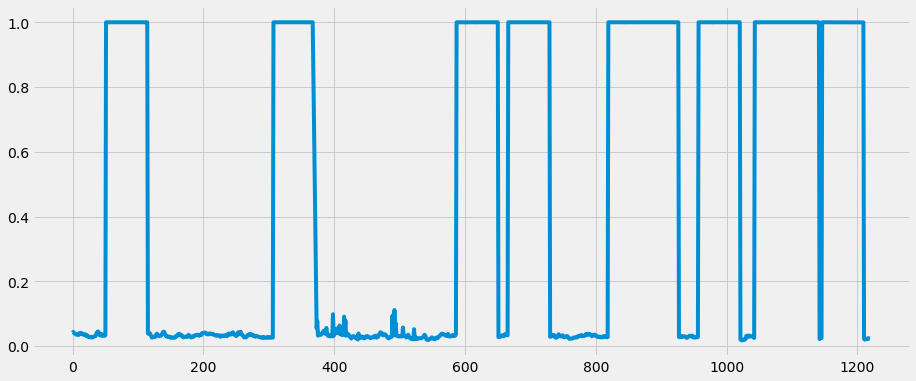

In [7]:
def get_unique_total_values_ratio(df, feature, plot=False, return_result=False):
    df_date_group = df.groupby('time_id').agg({feature: [lambda x: len(x.unique()), 'count']})
    df_date_group.columns.set_levels(['len_unique','count'], level=1,inplace=True)
    df_date_group['unique_count_ratio'] = df_date_group[feature]['len_unique']/df_date_group[feature]['count']
    df_date_group['num_or_cat'] = df_date_group['unique_count_ratio'].apply(lambda x: 1 if x > 0.5 else 0)
    if plot:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111)
        plt.plot(df_date_group.index, df_date_group['unique_count_ratio'] , label="Number of unique investments")
    if return_result:
        return df_date_group['num_or_cat']

get_unique_total_values_ratio(train, 'f_1', plot=True)

### f_7

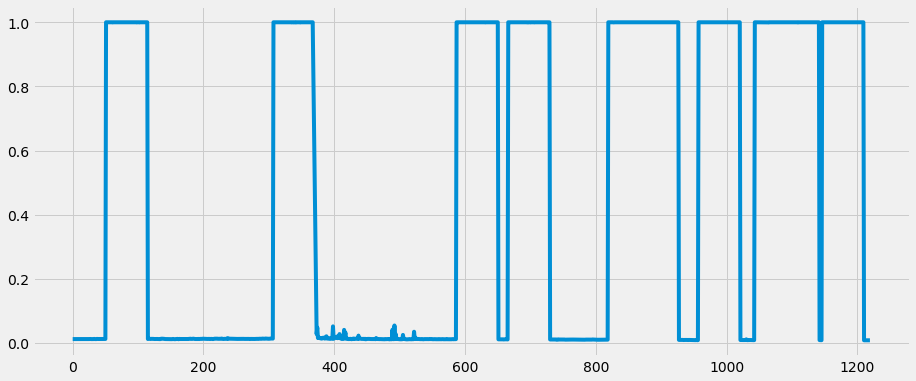

In [8]:
num_or_cat = get_unique_total_values_ratio(train, 'f_7', plot=True, return_result=True)

### Add time_id features

In [9]:
# time_id_df = (
#     train[["investment_id", "time_id"]]
#     .groupby("investment_id")
#     .agg(["min", "max", "count", np.ptp])
#     .assign(
#         time_span=lambda x: x.time_id.ptp,
#         time_count=lambda x: x.time_id["count"]
#     )
#     .drop(columns="ptp", level=1)
#     .reset_index()
# )
# time_id_df.head(6)

### Merge time features with train dataframe

In [10]:
# train = train.merge(time_id_df.drop(columns="time_id", level=0).droplevel(level=1, axis=1), on="investment_id", how='left')
# train[["time_span", "time_count"]].hist(bins=args.num_bins, figsize=(16,12), sharex=True, layout=(2,1))
# max_time_span=time_id_df.time_id["max"].max()
# outlier_investments = time_id_df.loc[time_id_df.time_id["count"]<32, "investment_id"].to_list()
# del time_id_df
# gc.collect()

### Add cluster feature

In [11]:
# inv_id_to_cluster = pd.read_pickle('../input/ubiquant-lgbm-models/clustered_inv_index.pkl')
inv_id_to_cluster = pd.read_pickle('clustered_inv_index.pkl')

train = train.merge(inv_id_to_cluster, how='left', on='investment_id')
train.cluster.fillna(0, inplace=True)

### Add time group feature

In [12]:
train.loc[(train['time_id'] < 910), 'group'] = 0
train.loc[(train['time_id'] >= 910) & (train['time_id'] < 970), 'group'] = 1
train.loc[(train['time_id'] >= 970) & (train['time_id'] < 1030), 'group'] = 2
train.loc[(train['time_id'] >= 1030) & (train['time_id'] < 1090), 'group'] = 3
train.loc[(train['time_id'] >= 1090) & (train['time_id'] < 1150), 'group'] = 4
train.loc[(train['time_id'] >= 1150), 'group'] = 5
train['group'] = train['group'].astype(np.int16)

### Add feature that shows if some features are categorical or numerical for the current time_id

In [13]:
# add numerical/categorical flag
train = train.merge(num_or_cat, how='left', on='time_id')

### Some features are not stationary. Let's make a rank transformation by time_id to make them stationary

In [14]:
train['f_74']  = train[['time_id', 'f_74']].groupby('time_id').rank(pct=True)
train['f_142']  = train[['time_id', 'f_142']].groupby('time_id').rank(pct=True)
train['f_63']  = train[['time_id', 'f_63']].groupby('time_id').rank(pct=True)

### Add total number of investment ids in the current time slot

In [15]:
# investment_id_df = (
#     train[["investment_id", "time_id"]]
#     .groupby("time_id")
#     .agg("count")
#     .rename({"investment_id": "number_of_inv_ids"}, axis=1)
#     .reset_index()
# )
# investment_id_df.head()

# train = train.merge(investment_id_df, how='left', on='time_id')

### Add lags

In [ ]:
features_with_lags = ['f_0', 'f_3', 'f_8', 'f_13', 'f_22', 'f_25', 'f_32', 
                      'f_41', 'f_59', 'f_61', 'f_62', 'f_63', 'f_67', 'f_68', 
                      'f_71', 'f_74', 'f_78', 'f_98', 'f_99', 'f_200', 'f_208',
                      'f_73', 'f_210', 'f_212', 'f_213', 'f_216', 'f_219', 
                      'f_225', 'f_229', 'f_231', 'f_240', 'f_241', 'f_244', 
                      'f_246', 'f_247', 'f_248', 'f_249', 'f_251', 'f_255', 
                      'f_259', 'f_263', 'f_267', 'f_268', 'f_269', 'f_271', 
                      'f_272', 'f_275', 'f_278', 'f_286', 'f_287', 'f_289', 
                      'f_291', 'f_293']

# features_with_lags = ['f_0', 'f_8', 'f_22', 'f_61', 'f_62', 'f_99', 'f_107', 
#                       'f_108', 'f_127', 'f_145', 'f_146', 'f_153', 'f_170', 
#                       'f_174', 'f_183', 'f_184', 'f_193', 'f_229', 'f_231', 
#                       'f_240', 'f_241', 'f_249', 'f_283']

time_id_unique = train.time_id.unique()

def get_next_time_id(s):
    next_idx = np.where(time_id_unique == s)[0][0] + 1
    if next_idx == len(time_id_unique):
        return time_id_unique[-1] + 1
    return time_id_unique[next_idx]
    
train_lag_1 = train[['time_id', 'investment_id'] + features_with_lags].copy()
train_lag_1.columns = ['time_id', 'investment_id'] + [f + '_lag_1' for f in train_lag_1.columns[2:]]
train_lag_1.time_id = train.time_id.apply(get_next_time_id)

train = train.merge(train_lag_1, how='left', on=['time_id', 'investment_id'])

num_features = [c for c in train.columns if c.startswith('f_')]
num_features += [f + '_lag_1' for f in features_with_lags]
train.fillna(train.target.mean(), inplace=True)
# train = train.query('time_id > 0')

del train_lag_1
gc.collect()

### Encode target by investment_id and cluster

In [ ]:
# from cuml.preprocessing import TargetEncoder

# te = TargetEncoder()

# train["investment_te"] = te.fit_transform(train["investment_id"], train["target"]).astype("float32")
# train["cluster_te"] = te.fit_transform(train["cluster"], train["target"]).astype("float32")

### Make combinations for some features and drop not necessary features.

In [ ]:
cat_features = ['num_or_cat', 'cluster']
features = num_features + cat_features + ['time_id']

# make feature combinations
combination_features = ["f_231-f_250", "f_118-f_280", "f_155-f_297", "f_25-f_237", "f_179-f_265", "f_119-f_270", "f_71-f_197", "f_21-f_65"]
for f in combination_features:
    f1, f2 = f.split("-")
    train[f] = train[f1] + train[f2]
features += combination_features

# drop unnecessary features
to_drop = ["f_148", "f_72", "f_49", "f_205", "f_228", "f_97", "f_262", "f_258"]
features = list(sorted(set(features).difference(set(to_drop))))
train = train.drop(columns=["row_id"] + to_drop)

features_backup = features.copy()
gc.collect()

### Reduce memory usage.

In [ ]:
%%time

train = reduce_mem_usage(train)
train[["investment_id", "time_id"]] = train[["investment_id", "time_id"]].astype(np.uint16)
gc.collect()

### Standard scale numerical features

In [ ]:
%%time

sscaler = StandardScaler()
features_to_scale = [c for c in train.columns if c.startswith('f_')]
train[features_to_scale] = sscaler.fit_transform(train[features_to_scale])

# Train

### Set scoring and training functions

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# TODO: replace with feval_pearsonr
def feval_rmse(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'rmse', rmse(y_true, y_pred), False

# https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
def feval_pearsonr(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'pearsonr', pearsonr(y_true, y_pred)[0], True

# https://www.kaggle.com/gogo827jz/jane-street-supervised-autoencoder-mlp?scriptVersionId=73762661
# weighted average as per Donate et al.'s formula
# https://doi.org/10.1016/j.neucom.2012.02.053
# [0.0625, 0.0625, 0.125, 0.25, 0.5] for 5 fold
def weighted_average(a):
    w = []
    n = len(a)
    for j in range(1, n + 1):
        j = 2 if j == 1 else j
        w.append(1 / (2**(n + 1 - j)))
    return np.average(a, weights = w)

def run(info):    
    # hyperparams from: https://www.kaggle.com/valleyzw/ubiquant-lgbm-optimization
    params = {
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'learning_rate':0.05,
        "objective": "regression",
        "metric": "rmse",
        'boosting_type': "gbdt",
        'verbosity': 0,
        'n_jobs': -1, 
        'seed': 42,
#         'lambda_l1': 0.03627602394442367, 
#         'lambda_l2': 0.43523855951142926, 
#         'num_leaves': 114, 
#         'feature_fraction': 0.9505625064462319, 
#         'bagging_fraction': 0.9785558707339647, 
#         'bagging_freq': 7, 
#         'max_depth': -1, 
#         'max_bin': 501, 
#         'min_data_in_leaf': 374,
        'n_estimators': 1000, 
    }
    
    y = train['target']
    train['preds'] = -1000
    scores = defaultdict(list)
    features_importance= []
    
    def run_lgbm(trn_ind, val_ind):
        train_dataset = lgb.Dataset(train.loc[trn_ind, features], y.loc[trn_ind], categorical_feature=cat_features)
        valid_dataset = lgb.Dataset(train.loc[val_ind, features], y.loc[val_ind], categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset, valid_dataset], 
            callbacks=[lgb.log_evaluation(50), lgb.early_stopping(stopping_rounds=50)],
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbm_seed_42_{info}.pkl')
        preds = model.predict(train.loc[val_ind, features])
        train.loc[val_ind, "preds"] = preds
        rmse_score = rmse(y.loc[val_ind], preds)
        pearsonr_score = pearsonr(y.loc[val_ind], preds)[0]
        features_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importance()})
        del train_dataset, valid_dataset
        gc.collect()
        return rmse_score, pearsonr_score, features_importance
        
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    print(f"train length: {trn_ind.sum()}, valid length: {val_ind.sum()}")
    rmse_score, pearsonr_score, features_importance = run_lgbm(trn_ind, val_ind)
    
#     train.filter(regex=r"^(?!f_).*").to_csv(f"preds_{info}.csv", index=False)
    return features_importance, scores

### Train with deafault params

In [ ]:
%%time

if args.train:
    info = ""
    features_importance, scores = run(info=info)
    df = train[["target", "preds", "time_id"]].query("preds!=-1000")
    pearsonr_by_time_id = df.groupby("time_id").apply(lambda x: pearsonr(x.target, x.preds)[0]).mean()
    print(f"lgbm rmse: {rmse(df.target, df.preds):.4f}, pearsonr: {pearsonr(df.target, df.preds)[0]:.4f}, pearsonr by time_id: {pearsonr_by_time_id:.4f}")

#     features_importance.to_csv(f"features_importance_{info}.csv", index=False)

    plt.figure(figsize=(16, 10))
    plt.subplot(1,2,1)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).head(50))
    plt.title(f'Head LightGBM Features {info}')
    plt.subplot(1,2,2)
    sns.barplot(x="importance", y="feature", data=features_importance.sort_values('importance', ascending=False).tail(50))
    plt.title(f'Tail LightGBM Features {info}')
    plt.tight_layout()
    plt.show()
    del df

# del train
# gc.collect()

### TR with StandardScaler

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913246	training's pearsonr: 0.145271	valid_1's rmse: 0.892437	valid_1's pearsonr: 0.130593
# [100]	training's rmse: 0.909629	training's pearsonr: 0.17339	valid_1's rmse: 0.891747	valid_1's pearsonr: 0.132084
# [150]	training's rmse: 0.906864	training's pearsonr: 0.192832	valid_1's rmse: 0.891166	valid_1's pearsonr: 0.135193
# [200]	training's rmse: 0.904389	training's pearsonr: 0.208756	valid_1's rmse: 0.890945	valid_1's pearsonr: 0.136029
# [250]	training's rmse: 0.902092	training's pearsonr: 0.222582	valid_1's rmse: 0.890723	valid_1's pearsonr: 0.137196
# [300]	training's rmse: 0.900141	training's pearsonr: 0.233832	valid_1's rmse: 0.890584	valid_1's pearsonr: 0.137981
# [350]	training's rmse: 0.898277	training's pearsonr: 0.244289	valid_1's rmse: 0.890514	valid_1's pearsonr: 0.138446
# [400]	training's rmse: 0.896562	training's pearsonr: 0.253708	valid_1's rmse: 0.890576	valid_1's pearsonr: 0.137937
# Early stopping, best iteration is:
# [371]	training's rmse: 0.897532	training's pearsonr: 0.248375	valid_1's rmse: 0.890461	valid_1's pearsonr: 0.13886
# lgbm  mean rmse: 0.8904606410516016, mean pearsonr: 0.13886018404151504
# lgbm  single 5 folds mean rmse: 0.8905, mean pearsonr: 0.1389, mean pearsonr by time_id: 0.1376

### All lag features

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913185	training's pearsonr: 0.146122	valid_1's rmse: 0.89232	valid_1's pearsonr: 0.132139
# [100]	training's rmse: 0.909577	training's pearsonr: 0.173878	valid_1's rmse: 0.891594	valid_1's pearsonr: 0.133594
# [150]	training's rmse: 0.906713	training's pearsonr: 0.193823	valid_1's rmse: 0.891072	valid_1's pearsonr: 0.135876
# [200]	training's rmse: 0.904312	training's pearsonr: 0.209246	valid_1's rmse: 0.890887	valid_1's pearsonr: 0.136333
# [250]	training's rmse: 0.902041	training's pearsonr: 0.223014	valid_1's rmse: 0.890756	valid_1's pearsonr: 0.136814
# Early stopping, best iteration is:
# [229]	training's rmse: 0.903008	training's pearsonr: 0.217111	valid_1's rmse: 0.890623	valid_1's pearsonr: 0.138162
# lgbm rmse: 0.8906, pearsonr: 0.1382, pearsonr by time_id: 0.1367

### New lag features

In [ ]:
# Training until validation scores don't improve for 50 rounds
# [50]	training's rmse: 0.913269	training's pearsonr: 0.145361	valid_1's rmse: 0.892617	valid_1's pearsonr: 0.1283
# [100]	training's rmse: 0.909648	training's pearsonr: 0.173243	valid_1's rmse: 0.891796	valid_1's pearsonr: 0.131634
# [150]	training's rmse: 0.906839	training's pearsonr: 0.192895	valid_1's rmse: 0.891455	valid_1's pearsonr: 0.132653
# [200]	training's rmse: 0.904461	training's pearsonr: 0.207804	valid_1's rmse: 0.891054	valid_1's pearsonr: 0.134885
# [250]	training's rmse: 0.902287	training's pearsonr: 0.220889	valid_1's rmse: 0.89083	valid_1's pearsonr: 0.136167
# [300]	training's rmse: 0.900304	training's pearsonr: 0.232503	valid_1's rmse: 0.890852	valid_1's pearsonr: 0.135767
# Early stopping, best iteration is:
# [251]	training's rmse: 0.902252	training's pearsonr: 0.221116	valid_1's rmse: 0.890824	valid_1's pearsonr: 0.136217
# lgbm rmse: 0.8908, pearsonr: 0.1362, pearsonr by time_id: 0.1346

### Old lag features

# Optimize LGBM with Optuna

In [ ]:
import optuna
import warnings
warnings.filterwarnings("ignore", module="lightgbm")
from sklearn.metrics import mean_squared_error

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302480
    def feval_pearsonr(y_pred, lgb_train):
        y_true = lgb_train.get_label()
        return 'pearsonr', pearsonr(y_true, y_pred)[0], True
    
    time_thresh = round(train.time_id.max() * 0.9)
    trn_ind, val_ind = train.time_id < time_thresh, train.time_id >= time_thresh
    
    X_train, y_train = train.loc[trn_ind, features], train.loc[trn_ind, 'target']
    X_val, y_val = train.loc[val_ind, features], train.loc[val_ind, 'target']
    
    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_val, y_val, categorical_feature=cat_features)

    param = {
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'objective': 'regression',
        'metric': 'rmse',
        'seed': 42,
        'verbosity': 0,
        'boosting_type': 'gbdt', # other options: rf, dart, goss
        'force_col_wise': False, # Use only with CPU devices
       
        'subsample_for_bin': 300000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time
        'n_estimators': trial.suggest_int('n_estimators', 500, 1200),      
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256), # Max number of leaves in one tree
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be 
                                                           # bucketed in. small number of bins may reduce training 
                                                           # accuracy but may deal with overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0), # Randomly select a subset of features 
                                                                               # if feature_fraction < 1.0
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0), # Randomly select part of data without 
                                                                               # resampling if bagging_fraction < 1.0
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7), # Perform bagging at every k iteration
        'min_data_in_leaf': trial.suggest_int('min_child_samples', 5, 100), # Minimal number of data in one leaf
                                                                            # aliases: min_child_samples, 
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-4, 1e-1), # Stop trying to split 
                                                                                               # leave if sum of it's
                                                                                               # hessian less than k
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0), # this can reduce the effect of noises in 
                                                                      # categorical features, especially for 
                                                                      # categories with few data
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'pearsonr', valid_name='valid_1')
    gbm = lgb.train(
        param, 
        train_set = dtrain, 
        valid_sets = [dtrain, dvalid], 
        feval = feval_pearsonr,
        callbacks = [lgb.log_evaluation(100),
                     pruning_callback]
    )

    y_pred = gbm.predict(X_val)
    corr = pearsonr(y_val, y_pred)[0]
    return corr


if args.optimize is True:
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=100), direction="maximize"
    )
    study.optimize(objective, timeout=10*3600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    
    

# Stacking best LGBM models

### Get best parameters

In [ ]:
if args.train_l2 is True:
#     lgb_params = study.trials_dataframe()
#     lgb_params.to_pickle('LGBM_Optuna_params.pkl')
    lgb_params = pd.read_pickle('LGBM_Optuna_params.pkl').sort_values('value', ascending=False).head(5)

    param_cols = [c for c in lgb_params.columns if c.startswith('params_')]
    lgb_params = lgb_params[param_cols]

    best_params = list()

    for idx, row in lgb_params.iterrows():
        row_dict = {k[7:]: v for k, v in row.items()}
        row_dict['device'] = 'gpu'
        row_dict['gpu_platform_id'] = 0
        row_dict['gpu_device_id'] = 0
        row_dict['verbosity'] = 0
        row_dict['max_bin'] = int(row_dict['max_bin'])
        row_dict['bagging_freq'] = int(row_dict['bagging_freq'])
        row_dict['min_child_samples'] = int(row_dict['min_child_samples'])
        row_dict['n_estimators'] = int(row_dict['n_estimators'])
        row_dict['num_leaves'] = int(row_dict['num_leaves'])
        best_params.append(row_dict)

### Create metafeatures for the train set

In [ ]:
if args.train_l2 is True:
    groups_level2 = [1, 2, 3, 4, 5]

    # That is how we get target for the 2nd level dataset
    y_train_level2 = train.loc[train.group.isin(groups_level2), 'target']

    # Create 1st level feature matrix
    X_train, y_train = train[features], train['target']
    
    # And here we create 2nd level feature matrix, init it with zeros first
    X_train_level2 = np.zeros([y_train_level2.shape[0], len(best_params)+1])
    X_train_level2[:, len(best_params)] = y_train_level2

    meta_index_begin = 0
    meta_index_end = 0

    # Now fill `X_train_level2` with metafeatures
    for current_group in tqdm(groups_level2):
        # split data
        train_index = X_train.loc[train.group <  current_group].index
        test_index  = X_train.loc[train.group == current_group].index

        X_train_l2 = X_train.loc[train_index, :]
        X_test_l2 =  X_train.loc[test_index, :]

        y_train_l2 = y_train[train_index]
        y_test_l2 =  y_train[test_index]

        meta_index_end += y_test_l2.shape[0]

        print(f"===================== time group: {current_group} =====================")
        
        # predict metafeatures for each of LGBM regressors
        for i, params in enumerate(tqdm(best_params)):
            print(f"===================== model: {i} =====================")
            train_dataset = lgb.Dataset(X_train_l2, y_train_l2, categorical_feature=cat_features)
            model = lgb.train(
                params,
                train_set = train_dataset, 
                valid_sets = [train_dataset], 
                callbacks = [lgb.log_evaluation(100)],
                feval = feval_pearsonr
            )
#             joblib.dump(model, f'lgbr_{i+1}.pkl')
            
            pred = model.predict(X_test_l2)
            X_train_level2[meta_index_begin:meta_index_end, i] = pred

            del train_dataset, model, pred
            gc.collect()

        meta_index_begin = meta_index_end

    X_train_level2 = pd.DataFrame(X_train_level2, columns=[f'lgbr_{i+1}' for i in range(len(best_params))]+['target'])
    X_train_level2.to_pickle('LGBM_X_train_level2.pkl')
    
    # train every LGB model on the full dataset and save it
    for i, params in enumerate(tqdm(best_params)):
        print(f"===================== model: {i} =====================")
        train_dataset = lgb.Dataset(X_train, y_train, categorical_feature=cat_features)
        model = lgb.train(
            params,
            train_set = train_dataset, 
            valid_sets = [train_dataset], 
            callbacks = [lgb.log_evaluation(100)],
            feval = feval_pearsonr
        )
        joblib.dump(model, f'lgbr_{i+1}.pkl')

    del X_train, y_train
    gc.collect()

# Fit LinearRegression for the second layer

In [ ]:
if args.train_l2 is True:
    X_train_level2 = joblib.load('../input/ubiquant-lgbm-models/LGBM_X_train_level2.pkl')

    X = X_train_level2[[c for c in X_train_level2.columns if c != 'target']]
    y = X_train_level2['target']

    lr = LinearRegression()
    lr.fit(X, y)

    joblib.dump(lr, 'lr.pkl')

# Inference

In [ ]:
import ubiquant

time_id = 1220
test_df_lag_1 = None

# Get dict for all clusters
investment_id_cluster_dict = dict()
for unique in train['cluster'].unique():
    investment_id_cluster_dict.update({unique: inv_id_to_cluster[inv_id_to_cluster['cluster'] == unique].index.to_numpy()})

def get_cluster_id(investment_id, investment_id_cluster_dict):
    clusters = np.zeros_like(investment_id.values)
    for i in range(len(clusters)):
        for k in investment_id_cluster_dict.keys():
            if investment_id.values[i] in investment_id_cluster_dict[k]:
                clusters[i] = k
    return clusters

def create_dummy_lag_cols(train_df, features_with_lags):
    test_df_lag_1 = test_df[['investment_id'] + features_with_lags].copy()
    test_df_lag_1.columns = ['investment_id'] + [f + '_lag_1' for f in test_df_lag_1.columns[1:]]
    test_df_lag_1[test_df_lag_1.columns[1:]] = 0
    return test_df_lag_1
    

if args.inference:
    env = ubiquant.make_env()  
    iter_test = env.iter_test()

    lr_model = joblib.load('../input/ubiquant-lgbm-models/lr.pkl')
    lgbr_models = list(map(joblib.load, sorted(Path("../input/ubiquant-lgbm-models").glob("lgbr_*.pkl"))))

    # https://www.kaggle.com/c/ubiquant-market-prediction/discussion/305353 
    # When making predictions check if the investment_id was in the train set
    for (test_df, sample_prediction_df) in iter_test:
        # get feature combinations
        for f in combination_features:
            f1, f2 = f.split("-")
            test_df[f] = test_df[f1] + test_df[f2]

        # add cluster features
        test_df['cluster'] = get_cluster_id(test_df['investment_id'], investment_id_cluster_dict)

        # extract time_id
        try:
            test_time_id = int(test_df['row_id'].values[0].split('_')[0]) # extract time_id from row_id
            test_df["time_id"] = test_time_id
        except:
            test_df["time_id"] = time_id
            test_time_id = 0
        # in case of error just increase time_id on 1
        if test_time_id:
            time_id = test_time_id + 1
        else:
            test_df["time_id"] = time_id
            time_id += 1
        
        # create num_or_cat feature for the test_df
        unqiues = len(test_df['f_7'].unique())
        if unqiues/len(test_df) > 0.5:
            test_df['num_or_cat'] = 0
        else:
            test_df['num_or_cat'] = 1

        # add lag features
#         if test_df_lag_1 is None:
#             test_df_lag_1 = create_dummy_lag_cols(train_df, features_with_lags)
            
        try:
            test_df = test_df.merge(test_df_lag_1, how='left', on=['investment_id']).fillna(0)
        except:
            test_df_lag_1 = create_dummy_lag_cols(train_df, features_with_lags)
            test_df = test_df.merge(test_df_lag_1, how='left', on=['investment_id'])

        test_df_lag_1 = test_df[['investment_id'] + features_with_lags].copy()      
        test_df_lag_1.columns = ['investment_id'] + [f + '_lag_1' for f in test_df_lag_1.columns[1:]]
        
        # standard scale numeric features
#         test_df[features_to_scale] = sscaler.transform(test_df[features_to_scale])
        
        # predict
        test_df["preds"] = lr_model.predict(np.stack([model.predict(test_df[features_backup]) for model in lgbr_models], axis=1))
        sample_prediction_df['target'] = test_df["preds"]
        env.predict(sample_prediction_df) 
#         display(sample_prediction_df)

# Further ideas


- f_165, f_197, f_76, f_237, f_206 - correlate with target lag 1
- f_259, f_69, f_21, f_130, f_81   - correlate with target lag 2 (f_259 has the highes corr)
- f_149, f_233, f_110, f_42, f_105 - correlate with target lag 3


- try custom loss function (for DNN) (https://www.kaggle.com/c/ubiquant-market-prediction/discussion/302181)

# What works for LGBM CV

- define if feature is numerical of categorical at this time period (num_or_cat)
- clipping of target (at 0.5% min/max)